<a href="https://colab.research.google.com/github/hobbang23/lecture/blob/main/NLP_LSTM_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install tf-nightly

  Using cached https://files.pythonhosted.org/packages/b3/a9/b1bc4c935ed063766bce7d3e8c7b20bd52e515ff1c732b02caacf7918e5a/numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tf-nightly 2.5.0.dev20201210 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


  Using cached https://files.pythonhosted.org/packages/87/86/753182c9085ba4936c0076269a571613387cdb77ae2bf537448bfd63472c/numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.DataFrame(pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep = '\t', quoting = 3))
train_df = train_df.replace(np.nan, '', regex=True) 
test_df = pd.DataFrame(pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep = '\t', quoting = 3))
test_df = test_df.replace(np.nan, '', regex=True)  #regex 정규표현식 설정 

print('train : ', len(train_df))
print('test : ', len(test_df))

train :  150000
test :  50000


In [ ]:
train_df.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


전처리 토큰화

In [ ]:
# 정규표현식(re)
# re.compile 

# 한글 제외한 다른 문자 모두 제거 
import re 
remove_except_ko = re.compile(r"^[가-힣ㄱ-ㅎㅏ-ㅣ\\s]")

#전처리 과정 함수화
def preprocess(text):
    text = re.sub(remove_except_ko, ' ',text).strip() #strip() 공백 지우기
    return text 

train_df['documet']=train_df['document'].map(lambda x : preprocess(x)) #mapping 해주기
test_df['documet']=test_df['document'].map(lambda x : preprocess(x))

train_df['document'][:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

Mecab 이용하여 형태소 분석

In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x


+ pip install konlpy
     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 43.6MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-

In [ ]:
import konlpy
konlpy.tag.Mecab().morphs('아버지가방에들어가신다')

['아버지', '가', '방', '에', '들어가', '신다']

tf_idf를 기반으로 단어를 벡터화

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
# Mecab 이용하여 토큰화, 한글자 제거, 불용어 제거 
stop_word = ['께서','에서', '이다','에게','으로', '이랑', '까지', '하다', '부터']

In [ ]:
# 전처리 함수 만들기 -> 한글 제거하고 불용어 처리하기 
def postagging_mecab(text):
    text = mecab.morphs(text)
    text = [i for i in text if len(i) > 1] #한글자 제거 
    text = [i for i in text if i not in stop_word] #불용어 처리
    return(text)

In [ ]:
# 토큰화 + 토큰 리스트 만들기
def make_tokens(df):
    df['tokens'] = '' #데이터 프레임에 tokens 자리 만들기
    tokens_list = [] #토큰 리스트 자리 만들기
    for i,row in df.iterrows(): #iterrows : 인덱스 판다스 1차원 데이터인 series로 만들어 접근
        if i%10000==0: #10000개씩 나누기 
            print(i, '/', len(df)) 
        token = postagging_mecab(df['documet'][i])
        tokens_list.append(token)
    return tokens_list,df 
train_list, train_df = make_tokens(train_df)
test_list, test_df = make_tokens(test_df)

0 / 150000
10000 / 150000
20000 / 150000
30000 / 150000
40000 / 150000
50000 / 150000
60000 / 150000
70000 / 150000
80000 / 150000
90000 / 150000
100000 / 150000
110000 / 150000
120000 / 150000
130000 / 150000
140000 / 150000
0 / 50000
10000 / 50000
20000 / 50000
30000 / 50000
40000 / 50000


토큰화된 단어 벡터화

In [ ]:
%matplotlib inline 

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_list)

In [ ]:
#word set 
print(tokenizer.word_index)

{'영화': 1, '..': 2, '는데': 3, '너무': 4, '네요': 5, '지만': 6, '재밌': 7, 'ㅋㅋ': 8, '정말': 9, '연기': 10, '진짜': 11, '...': 12, '어요': 13, '습니다': 14, '최고': 15, 'ㅋㅋㅋ': 16, '아니': 17, '드라마': 18, '생각': 19, '사람': 20, '스토리': 21, '평점': 22, '이런': 23, '감동': 24, '만들': 25, '배우': 26, '보다': 27, '내용': 28, '10': 29, '재미': 30, '감독': 31, '시간': 32, '지루': 33, '라고': 34, '사랑': 35, '면서': 36, '재미있': 37, '나오': 38, '그냥': 39, '쓰레기': 40, '하나': 41, '재미없': 42, '작품': 43, '해서': 44, '정도': 45, '다시': 46, '입니다': 47, '라는': 48, '다는': 49, '아깝': 50, '장면': 51, '다가': 52, '으면': 53, '모르': 54, '액션': 55, '느낌': 56, '기대': 57, '어서': 58, '마지막': 59, '이야기': 60, '봐도': 61, '인데': 62, '이렇게': 63, '다고': 64, 'ㅠㅠ': 65, '^^': 66, '그리고': 67, '처음': 68, '이건': 69, '는지': 70, '이해': 71, '만든': 72, '이상': 73, '합니다': 74, '!!': 75, '많이': 76, '최악': 77, '이거': 78, '지금': 79, '명작': 80, '완전': 81, '한다': 82, '때문': 83, '이나': 84, '주인공': 85, '별로': 86, 'ㅎㅎ': 87, '여자': 88, '기억': 89, '연출': 90, '괜찮': 91, '내내': 92, 'ㅡㅡ': 93, '세요': 94, '한국': 95, '아서': 96, '~~': 97, '전개': 98, '아요': 99, '현실

In [ ]:
#단어를 숫자배열로 변환 
X_train_array_list = tokenizer.texts_to_sequences(train_list)
X_test_array_list = tokenizer.texts_to_sequences(test_list)
X_train = X_train_array_list #다시 X_train 에 넣어주기 
X_test = X_test_array_list #다시 X_text에 넣어주기 

X_train, X_test #숫자 배열 변화 

([[11, 107, 5, 457],
  [12, 440, 302, 498, 1, 12, 1188, 10, 564, 822, 186],
  [3579, 28625],
  [28626, 60, 3253, 338, 30, 22, 2708],
  [21231,
   21232,
   8240,
   688,
   10,
   2070,
   1,
   2279,
   172,
   21233,
   12934,
   296,
   2390,
   1189],
  [21234, 1685, 407, 1122, 1, 16, 2, 2071, 437],
  [218, 200, 1445, 492],
  [962,
   50,
   445,
   9592,
   14762,
   10,
   1029,
   112,
   9,
   176,
   376,
   308,
   2929,
   8241,
   998,
   998,
   18,
   169,
   10,
   20,
   28627],
  [3, 30, 1],
  [22, 448, 7260, 1202, 549, 4, 14763],
  [6144, 11],
  [224, 1999, 458, 2000, 615, 17319, 425, 2211, 1580, 5610],
  [36, 12935, 28628, 6471, 28629, 17320, 3580, 10, 952, 1220],
  [928, 44, 9593, 2001, 27, 598, 28630, 20, 49],
  [3178, 17321, 11, 2869, 194, 1, 117, 24, 21, 847, 24, 3411],
  [2212, 953, 65],
  [20,
   797,
   8866,
   28631,
   12936,
   34,
   4512,
   954,
   1167,
   34,
   17322,
   39,
   58,
   6859,
   129,
   881],
  [4215, 12937, 929, 71, 3, 354, 42],
  [9,

In [ ]:
# 레이블링 데이터 행렬변환
Y_train = np.array(train_df['label'])
Y_test = np.array(test_df['label'])
print('훈련데이터 : ',len(X_train_array_list))

훈련데이터 :  150000


In [ ]:
print(train_list[:2])
print(X_train_array_list[:2])

[['진짜', '짜증', '네요', '목소리'], ['...', '포스터', '보고', '초딩', '영화', '...', '오버', '연기', '조차', '가볍', '구나']]
[[11, 107, 5, 457], [12, 440, 302, 498, 1, 12, 1188, 10, 564, 822, 186]]


패딩 (입력값의 길이를 맞춰주는 작업)

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 7.357866666666666


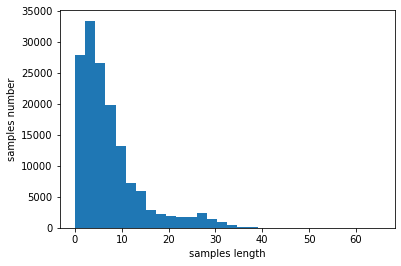

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in X_train], bins=30)
plt.xlabel('samples length')
plt.ylabel('samples number')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list): #threshold : 한계점
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1 
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100)) # 최대 개수 / 전체 개수 x100
max_len = 35
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 99.882


In [ ]:
# 데이터 길이 35로 패딩해주기 
max_len = 35
X_train = pad_sequences(X_train, maxlen = max_len) #패딩 해준 값 다시 X_train에 넣기 
X_test = pad_sequences(X_test, maxlen = max_len) 
len(X_train), X_train.shape

(150000, (150000, 35))

In [ ]:
X_train, Y_train

(array([[    0,     0,     0, ...,   107,     5,   457],
        [    0,     0,     0, ...,   564,   822,   186],
        [    0,     0,     0, ...,     0,  3579, 28625],
        ...,
        [    0,     0,     0, ..., 14281, 11290,  2152],
        [    0,     0,     0, ...,  2628,   936,  7409],
        [    0,     0,     0, ...,    28,  2012,     1]], dtype=int32),
 array([0, 1, 0, ..., 0, 1, 0]))

감성분석(LSTM)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model #모델 저장하고 불러들이기
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
vocab_size = len(X_train)
vocab_size

150000

In [ ]:
# 신경망 층, 레이어 쌓아주기
# 모델 설정하고 실행하는 부분 
model = Sequential() #케라스는 층을 조합하여 모델을 만든다 -> 즉, 모델은 층의 그래프라고 보면 된다
# model.add(...) 는 층을 추가하는 것을 의미함
model.add(Embedding(vocab_size, 100)) #층을 형성
model.add(LSTM(128))
model.add(Dense(128, activation='relu')) # 첫번째 층 
model.add(Dense(1, activation='sigmoid')) # 두번째 층

모델저장방법

In [ ]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합이 될수 있기 때문에 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping). 
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('review_data.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

모델 학습

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# loss는 crossentropy 
history = model.fit(X_train, Y_train, epochs=5, batch_size=100)

Epoch 1/5
1500/1500 [==============================] - 248s 165ms/step - loss: 0.2811 - acc: 0.8775
Epoch 2/5
1500/1500 [==============================] - 249s 166ms/step - loss: 0.2633 - acc: 0.8850
Epoch 3/5
1500/1500 [==============================] - 254s 169ms/step - loss: 0.2476 - acc: 0.8920
Epoch 4/5
1500/1500 [==============================] - 253s 168ms/step - loss: 0.2324 - acc: 0.8985
Epoch 5/5
1500/1500 [==============================] - 250s 167ms/step - loss: 0.2179 - acc: 0.9042


In [1]:
model.save('review_data.h5')
loaded_model=load_model('review_data.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1])) # 모델 평가하기 

NameError: ignored

In [ ]:
def predict_pos_text(text):
    token=[]
    tokens = postagging_mecab(text) 
    token.append(tokens)
    print(token) #새로 들어온 텍스트 토큰화 

    X_train_arrary_list = tokenizer.texts_to_sequences(token) #정수 인코딩
    max_len=30 # 패딩
    X_train = pad_sequences(X_train_arrary_list, maxlen = max_len) 

    score = float(loaded_model.predict(X_train)) # 점수 예측 
  
    print('score:', type(score))
    if score>0.5:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))

In [ ]:
#검증하기
predict_pos_text('3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??')